In [1]:
import numpy as np
import pandas as pd
import pickle
import h5py
from processing_helper_functions import final_processing
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# Variables to choose which downsampling technique, time series encoding technique, and other settings to use

# Which year of past data you would like to train on. One of: 0, 1, 2 where 0 is most recent and 2 is least recent
# If you want to train on more than one year, enter the least recent year to include
years_data = 0
# Set to True if you want to only train on 1 year of data
# Set to False to train on all data through years variable above
only_one = True
# Which time encoding technique should be used
# One of: 'all', 'slopes', 'all_ma', 'sma', 'ema'
encode_method = 'all'
# Which set of features should be used
# One of: 'baseline_demographics_cols', 'baseline_mci_cols', 'baseline_mmse30_cols', 'baseline_linear_selected_features',
# 'simplified_cols_withapoe', 'simplified_cols_withoutapoe', 'all_cols'
feature_set = 'all_cols'
# Which downsampling technique should be used
# One of: 'randdownsample', 'matcheddownsample', 'train', 'weighted'
sample_type = "train"

In [5]:
encode_suffix = encode_method
if encode_method in ['all','current']:
    encode_suffix = str(years_data+1)
if encode_method == 'ema':
    encode_suffix = encode_method+str(half_life)
if only_one:
    save_suffix = '%s_%s_2yrprev_within3_singleyear%s'%(sample_type, feature_set, str(int(encode_suffix)-1))
else:
    save_suffix = '%s_%s_2yrprev_within3_yrsincluded%s'%(sample_type, feature_set, encode_suffix)

file_suffix = "2yrprev_within3"
with h5py.File("../DATA/PROCESSED/standardized_stacked_imputed/%s.h5"%file_suffix, 'r') as hf:
    ALL_SAMPLES = hf["samples"][:]
    ALL_FEATURES_TIME = hf["features"][:]
DATA = pd.read_csv("../DATA/PROCESSED/standardized/merged_kept_data_%s.csv"%file_suffix, index_col=0)
ALL_SAMPLES_df = pd.DataFrame(ALL_SAMPLES, columns=["projid","fu_year","onset_label_time","onset_label_time_binary"])
    
constructed_data = final_processing(encode_method, years_data, only_one, feature_set, DATA.columns[6:], ALL_FEATURES_TIME)

# Train Models

[14:44:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




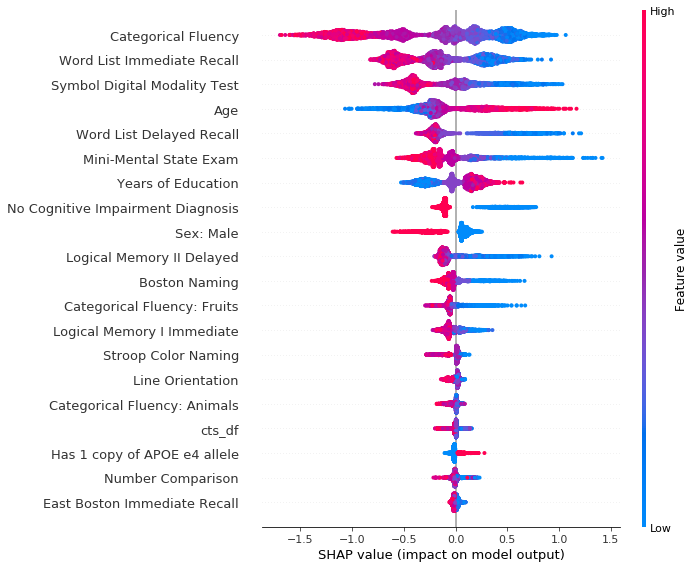

[14:44:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




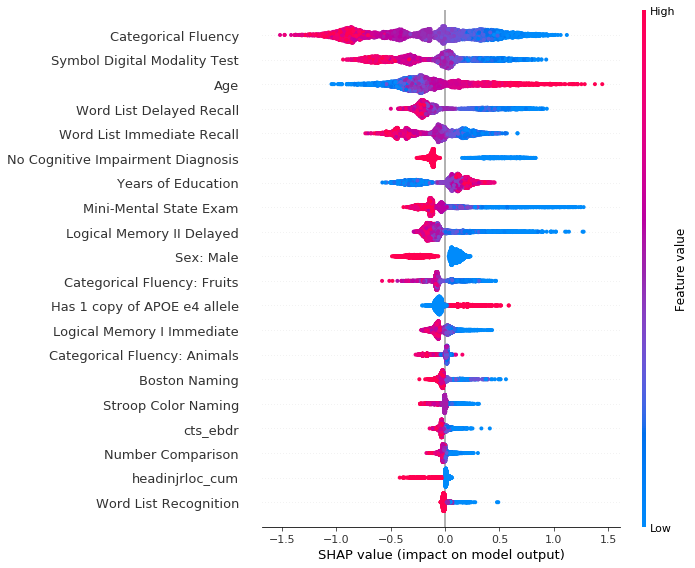

[14:44:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




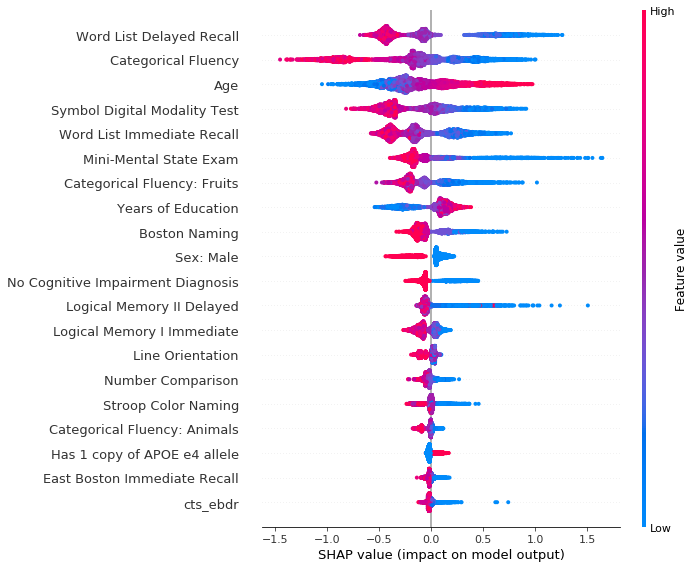

[14:44:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




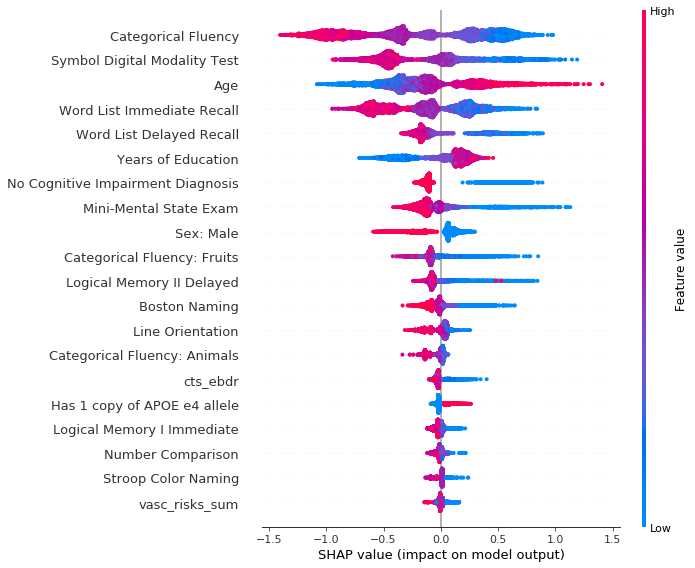

[14:44:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




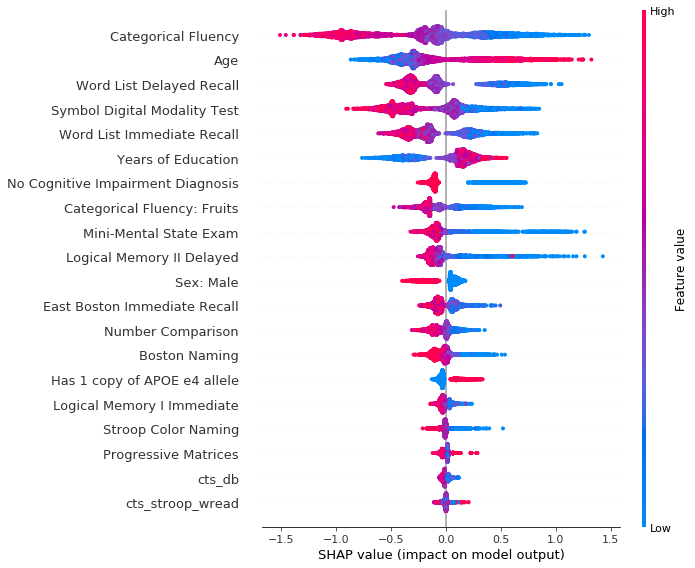

In [8]:
# GBDT
for i in range(5):

    accuracy_save = []
    roc_auc_save = []
    pr_auc_save = []
    precision_save = []
    recall_save = []
    fpr_save = []
    tpr_save = []
    
    if sample_type in ['randdownsample','matcheddownsample']:
        train_samples_df = pd.read_csv("../DATA/PROCESSED/split_projids/CV_splits/%i/%s_train_%s.txt"%(i,sample_type,file_suffix),index_col=0).drop_duplicates()
        train_samples_df["keep"]=1
        data_train = pd.merge(DATA, train_samples_df, on=['projid','fu_year'], how='left')
        train_idx = (data_train["keep"]==1).values
    else:
        train_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("../DATA/PROCESSED/split_projids/CV_splits/%i/train_%s.txt"%(i,file_suffix))).values
    valid_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("../DATA/PROCESSED/split_projids/CV_splits/%i/valid_%s.txt"%(i,file_suffix))).values

    label_col = np.where(ALL_SAMPLES_df.columns.values=='onset_label_time_binary')[0][0]
    label_tr = ALL_SAMPLES[train_idx][:, label_col]
    label_val = ALL_SAMPLES[valid_idx][:, label_col] 
    data_tr = constructed_data[train_idx]
    data_val = constructed_data[valid_idx]

    if sample_type == 'weighted':
        weight_tr = label_tr.astype(float)
        weight_tr[weight_tr==0] = np.sum(weight_tr)/(weight_tr.shape[0]-np.sum(weight_tr))
        dmat_train = xgb.DMatrix(data_tr.fillna(-999.0), label=label_tr, missing=-999.0, weight=weight_tr)
    else:
        dmat_train = xgb.DMatrix(data_tr.fillna(-999.0), label=label_tr, missing=-999.0)
    
    dmat_test = xgb.DMatrix(data_val.fillna(-999.0), label=label_val, missing=-999.0)
    num_round = 50
    param = {'silent':1, 'min_child_weight':0.25, 'eta':0.1, 'max_depth': 4, 'objective': 'binary:logistic', 'eval_metric': ['error','logloss']}
    model = xgb.train(param, dmat_train, num_boost_round=num_round, evals=[(dmat_train,'train'), (dmat_test,'eval')], early_stopping_rounds=5, verbose_eval=False)

    predr = model.predict(dmat_test, ntree_limit=model.best_iteration)
    accuracy_save.append(metrics.accuracy_score(label_val,np.round(predr)))
    fpr, tpr, _ = metrics.roc_curve(label_val,predr)
    fpr_save = fpr
    tpr_save = tpr
    roc_auc_save.append(metrics.auc(fpr,tpr))
    precision, recall, _ = metrics.precision_recall_curve(label_val,predr)
    precision_save.append(precision)
    recall_save.append(recall)
    pr_auc_save.append(metrics.auc(recall, precision))
    new_results = [accuracy_save,roc_auc_save,pr_auc_save,precision_save,recall_save,fpr_save,tpr_save]
    #pickle.dump(new_results, open('../results/CV/%i/xgb_%s.p'%(i,save_suffix), 'wb'))
    #pickle.dump(model, open('../results/CV/%i/xgb_%s.dat'%(i,save_suffix), "wb"))

In [31]:
# Linear
for i in range(5):
    accuracy_save = []
    roc_auc_save = []
    pr_auc_save = []
    precision_save = []
    recall_save = []
    fpr_save = []
    tpr_save = []

    if sample_type in ['randdownsample','matcheddownsample']:
        train_samples_df = pd.read_csv("../DATA/PROCESSED/split_projids/CV_splits/%i/%s_train_%s.txt"%(i,sample_type,file_suffix),index_col=0).drop_duplicates()
        train_samples_df["keep"]=1
        data_train = pd.merge(DATA, train_samples_df, on=['projid','fu_year'], how='left')
        train_idx = (data_train["keep"]==1).values
    else:
        train_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("../DATA/PROCESSED/split_projids/CV_splits/%i/train_%s.txt"%(i,file_suffix))).values
    valid_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("../DATA/PROCESSED/split_projids/CV_splits/%i/valid_%s.txt"%(i,file_suffix))).values

    label_col = np.where(ALL_SAMPLES_df.columns.values=='onset_label_time_binary')[0][0]
    label_tr = ALL_SAMPLES[train_idx][:, label_col]
    label_val =ALL_SAMPLES[valid_idx][:, label_col] 
    data_tr = constructed_data[train_idx]
    data_val = constructed_data[valid_idx]

    if sample_type == 'weighted':
        weight_tr = label_tr.astype(float)
        weight_tr_val = np.sum(weight_tr)/(weight_tr.shape[0]-np.sum(weight_tr))
        clf = LogisticRegression(class_weight={0: weight_tr_val, 1: 1})
    else:
        clf = LogisticRegression()
    clf.fit(data_tr, label_tr)

    accuracy_save.append(clf.score(data_val, label_val))
    roc_auc_save.append(metrics.roc_auc_score(label_val, clf.decision_function(data_val)))
    pr_auc_save.append(metrics.average_precision_score(label_val, clf.decision_function(data_val)))   
    fpr_save, tpr_save, _ = metrics.roc_curve(label_val, clf.decision_function(data_val))
    precision_save, recall_save, _ = metrics.precision_recall_curve(label_val, clf.decision_function(data_val))

    new_results = [accuracy_save,roc_auc_save,pr_auc_save,precision_save,recall_save,fpr_save,tpr_save]
    pickle.dump(new_results, open('../results/CV/%i/linear_%s.p'%(i,save_suffix), 'wb'))
    pickle.dump(clf, open('../results/CV/%i/linear_%s.dat'%(i,save_suffix), "wb"))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur